In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utils

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import random
from google.colab.patches import cv2_imshow

import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 랜덤 시드 설정
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)



In [3]:
cd /content/drive/MyDrive

/content/drive/MyDrive


## Custom Dataset

In [4]:
class SatelliteDataset(Dataset):
    def __init__(self, root_dir, transform=None, infer=False):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'binary_masks')
        self.image_filenames = os.listdir(self.image_dir)

        self.infer = infer
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace('.jpg', '.tif')) #확장자 명만 다름

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #jpg랑 cv2에서 RGB 순서 다름.

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = mask/255

        #전처리입니다.
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [ ]:
 #os.kill(os.getpid(), 9)

## Define Model

In [5]:
class DoubleConv(nn.Module):
    """반복되는 conv - BN - ReLU 구조 모듈화"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

## Hyper Parameters

In [11]:
lr= 0.001
epochs = 50
batch_size = 16


## Data Loader

In [12]:
transform = A.Compose( #학습 전 이미지 불러올때 전처리 결정. 일반적인 image 전처리 수행
    [
        A.Resize(384, 384),
        A.Normalize(),
        ToTensorV2()
    ]
)

train_dataset = SatelliteDataset(root_dir='./data/train', transform=transform) #train data 폴더 경로 넣기.
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)

In [13]:
dataset_size =  len(train_dataset)
# 10%의 Random dataset 데이터셋 생성
subset_size = int(0.1 * dataset_size )
subset_indices = torch.randperm(dataset_size)[:subset_size]
subset_dataset = Subset(train_dataset, subset_indices)
subset_dataloader = DataLoader(subset_dataset, batch_size, shuffle=True, num_workers=2)

In [14]:
test_dataset = SatelliteDataset(root_dir='./data/test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2)

dataset_size =  len(test_dataset)
# 10%의 Random dataset 데이터셋 생성
subset_size = int(0.2 * dataset_size)
subset_indices = torch.randperm(dataset_size)[:subset_size]
mini_test = Subset(test_dataset, subset_indices)
mini_test_loader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=2)

## Model Train

In [15]:
# model 초기화
model = UNet(3,1).to(device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

#### 10%로만 할지 말지 ####
train_dataloader = subset_dataloader

train_losses = []
test_losses = []

# training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_dataloader):
      images = images.float().to(device)
      masks = masks.float().to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, masks.unsqueeze(1))

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
    train_losses.append(epoch_loss/len(train_dataloader))

    test_loss=0
    with torch.no_grad():
      model.eval()
      result = []
      for images, masks in tqdm(mini_test_loader):
          images = images.float().to(device)
          masks = masks.float().to(device)

          outputs = model(images)
          loss = criterion(outputs, masks.unsqueeze(1))
          test_loss += loss.item()
    test_losses.append(test_loss/len(mini_test_loader))


    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_dataloader)}, Test Loss : {test_loss/len(mini_test_loader)}')



100%|██████████| 36/36 [05:16<00:00,  8.78s/it]


Epoch 1, Loss: 0.5160068511962891, Test Loss : 1.084980731209119


100%|██████████| 36/36 [00:15<00:00,  2.32it/s]


Epoch 2, Loss: 0.39068424503008525, Test Loss : 0.46804464525646633


100%|██████████| 36/36 [00:15<00:00,  2.30it/s]


Epoch 3, Loss: 0.3368978420893351, Test Loss : 0.9181109393636385


100%|██████████| 36/36 [00:16<00:00,  2.23it/s]


Epoch 4, Loss: 0.306594971815745, Test Loss : 0.3307874993317657


100%|██████████| 36/36 [00:15<00:00,  2.25it/s]


Epoch 5, Loss: 0.29243653217951454, Test Loss : 0.362908483379417


100%|██████████| 36/36 [00:16<00:00,  2.23it/s]


Epoch 6, Loss: 0.27630319197972614, Test Loss : 0.28583058300945496


100%|██████████| 36/36 [00:16<00:00,  2.23it/s]


Epoch 7, Loss: 0.266687473654747, Test Loss : 0.27072396584682995


100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


Epoch 8, Loss: 0.2535381317138672, Test Loss : 0.27729874642358887


100%|██████████| 36/36 [00:15<00:00,  2.28it/s]


Epoch 9, Loss: 0.25017126500606535, Test Loss : 0.3216021822558509


100%|██████████| 36/36 [00:15<00:00,  2.32it/s]


Epoch 10, Loss: 0.2487870544195175, Test Loss : 0.3912597762213813


100%|██████████| 36/36 [00:15<00:00,  2.35it/s]


Epoch 11, Loss: 0.24062556624412537, Test Loss : 0.2525011710822582


100%|██████████| 36/36 [00:15<00:00,  2.32it/s]


Epoch 12, Loss: 0.2323239654302597, Test Loss : 0.3163408488035202


100%|██████████| 36/36 [00:15<00:00,  2.31it/s]


Epoch 13, Loss: 0.22523303031921388, Test Loss : 0.34759141753117245


100%|██████████| 36/36 [00:15<00:00,  2.29it/s]


Epoch 14, Loss: 0.2329444338877996, Test Loss : 0.2408369498120414


100%|██████████| 36/36 [00:15<00:00,  2.33it/s]


Epoch 15, Loss: 0.21601350704828898, Test Loss : 0.24915844574570656


100%|██████████| 36/36 [00:15<00:00,  2.36it/s]


Epoch 16, Loss: 0.21476248304049175, Test Loss : 0.29388971792327034


100%|██████████| 36/36 [00:15<00:00,  2.34it/s]


Epoch 17, Loss: 0.21129029989242554, Test Loss : 0.22259624509347808


100%|██████████| 36/36 [00:15<00:00,  2.33it/s]


Epoch 18, Loss: 0.21309526960055034, Test Loss : 0.28670547902584076


100%|██████████| 36/36 [00:15<00:00,  2.31it/s]


Epoch 19, Loss: 0.2030336876710256, Test Loss : 0.2327354136440489


100%|██████████| 36/36 [00:15<00:00,  2.31it/s]


Epoch 20, Loss: 0.19306369125843048, Test Loss : 0.2760522812604904


100%|██████████| 36/36 [00:15<00:00,  2.33it/s]


Epoch 21, Loss: 0.21336143612861633, Test Loss : 0.23416104747189415


100%|██████████| 36/36 [00:15<00:00,  2.34it/s]


Epoch 22, Loss: 0.1960879921913147, Test Loss : 0.24772599091132483


100%|██████████| 36/36 [00:15<00:00,  2.31it/s]


Epoch 23, Loss: 0.19259310364723206, Test Loss : 0.23635232862499025


100%|██████████| 36/36 [00:15<00:00,  2.32it/s]


Epoch 24, Loss: 0.20034565031528473, Test Loss : 0.21800549659464094


100%|██████████| 36/36 [00:15<00:00,  2.30it/s]


Epoch 25, Loss: 0.19016748170057932, Test Loss : 0.2132629230618477


100%|██████████| 36/36 [00:15<00:00,  2.29it/s]


Epoch 26, Loss: 0.19088264604409536, Test Loss : 0.2103214959303538


100%|██████████| 36/36 [00:15<00:00,  2.28it/s]


Epoch 27, Loss: 0.1821583112080892, Test Loss : 0.2244999036192894


100%|██████████| 36/36 [00:15<00:00,  2.33it/s]


Epoch 28, Loss: 0.18426541189352671, Test Loss : 0.23419898831182057


100%|██████████| 36/36 [00:15<00:00,  2.33it/s]


Epoch 29, Loss: 0.17260428965091706, Test Loss : 0.2145314547750685


100%|██████████| 36/36 [00:15<00:00,  2.32it/s]


Epoch 30, Loss: 0.17644499540328978, Test Loss : 0.2173914619617992


100%|██████████| 36/36 [00:15<00:00,  2.32it/s]


Epoch 31, Loss: 0.17359742124875385, Test Loss : 0.21054704238971075


100%|██████████| 36/36 [00:15<00:00,  2.29it/s]


Epoch 32, Loss: 0.16915153563022614, Test Loss : 0.20824776051772964


100%|██████████| 36/36 [00:15<00:00,  2.34it/s]


Epoch 33, Loss: 0.1648424670100212, Test Loss : 0.2503853821092182


100%|██████████| 36/36 [00:15<00:00,  2.34it/s]


Epoch 34, Loss: 0.18138870298862458, Test Loss : 0.22730465026365387


100%|██████████| 36/36 [00:15<00:00,  2.33it/s]


Epoch 35, Loss: 0.17442893385887145, Test Loss : 0.21323391960726845


100%|██████████| 36/36 [00:15<00:00,  2.33it/s]


Epoch 36, Loss: 0.1787976731856664, Test Loss : 0.20893286706672776


100%|██████████| 36/36 [00:15<00:00,  2.33it/s]


Epoch 37, Loss: 0.176015268266201, Test Loss : 0.20606176430980364


100%|██████████| 36/36 [00:15<00:00,  2.36it/s]


Epoch 38, Loss: 0.16833330939213434, Test Loss : 0.2046135732283195


100%|██████████| 36/36 [00:15<00:00,  2.34it/s]


Epoch 39, Loss: 0.17883358349402745, Test Loss : 0.21581896187530625


100%|██████████| 36/36 [00:15<00:00,  2.33it/s]


Epoch 40, Loss: 0.16655237327019373, Test Loss : 0.247300294538339


100%|██████████| 36/36 [00:15<00:00,  2.32it/s]


Epoch 41, Loss: 0.16615523447593053, Test Loss : 0.21180804404947493


100%|██████████| 36/36 [00:15<00:00,  2.36it/s]


Epoch 42, Loss: 0.15996921161810557, Test Loss : 0.21000840846035215


100%|██████████| 36/36 [00:15<00:00,  2.31it/s]


Epoch 43, Loss: 0.15093567669391633, Test Loss : 0.19520458082358041


100%|██████████| 36/36 [00:15<00:00,  2.30it/s]


Epoch 44, Loss: 0.14360288679599761, Test Loss : 0.1984708487159676


100%|██████████| 36/36 [00:15<00:00,  2.34it/s]


Epoch 45, Loss: 0.1480502779285113, Test Loss : 0.19625068000621265


100%|██████████| 36/36 [00:15<00:00,  2.29it/s]


Epoch 46, Loss: 0.14014253268639246, Test Loss : 0.19458681551946533


100%|██████████| 36/36 [00:15<00:00,  2.33it/s]


Epoch 47, Loss: 0.14738605817159017, Test Loss : 0.2027643360197544


100%|██████████| 36/36 [00:15<00:00,  2.31it/s]


Epoch 48, Loss: 0.14521271288394927, Test Loss : 0.21710473423202833


100%|██████████| 36/36 [00:15<00:00,  2.30it/s]


Epoch 49, Loss: 0.15144580801328023, Test Loss : 0.20504717321859467


100%|██████████| 36/36 [00:15<00:00,  2.32it/s]

Epoch 50, Loss: 0.14789145737886428, Test Loss : 0.23183365621500546


In [16]:
torch.save(model.state_dict(), './model.pt')

## Epoch에 따른 Loss 변화

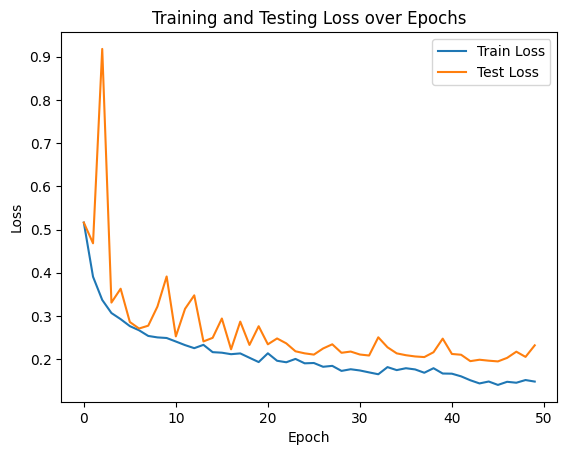

In [17]:
test_losses[0]= train_losses[0] #첫 test loss 너무커서
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 잘 되는지 결과 이미지 출력해보기

In [18]:
model = UNet(3,1).to(device)
model.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>

(384, 384)
True mask


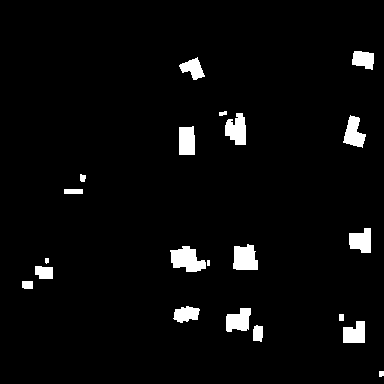

Output of our model


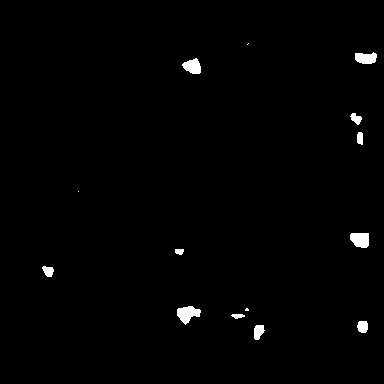

In [19]:
with torch.no_grad():
    model.eval()
    img = train_dataset[0][0].unsqueeze(0).float().to(device)
    true_mask = train_dataset[0][1].cpu().numpy()*255
    print(true_mask.shape)
    print('True mask')
    cv2_imshow(true_mask)

    print('Output of our model')
    output = model(img)
    output = torch.sigmoid(output).squeeze(0).permute(1,2,0).cpu().numpy() #output에 sigmoid => 건물일 확률 + shape 이미지 RGB 모양으로
    output = (output > 0.5).astype(np.uint8) # Threshold = 0.5 이상이면 건물이라 판단
    output = output*255 # 1이면 하얗게 출력하기 위해 255 곱하기


    cv2_imshow(output)


## Inference 및 최종 성능 평가

In [20]:
all_true_masks = []
all_predicted_masks = []
with torch.no_grad():
    model.eval()
    result = []
    for images, masks in tqdm(mini_test_loader):
        images = images.float().to(device)
        true_masks = masks.float().to(device)

        outputs = model(images)

        # CPU로 이동
        true_masks = true_masks.squeeze().cpu().numpy()
        outputs = outputs.squeeze().cpu().numpy()
        outputs = (outputs > 0.5).astype(np.uint8)


        # 리스트에 추가
        all_true_masks.extend(true_masks)
        all_predicted_masks.extend(outputs)

# 실제 마스크와 예측 마스크 비교
true_masks_flat = np.concatenate(all_true_masks).ravel()
predicted_masks_flat = np.concatenate(all_predicted_masks).ravel()

# Precision, Recall, IoU, Dice 계산
precision = precision_score(true_masks_flat, predicted_masks_flat)
recall = recall_score(true_masks_flat, predicted_masks_flat)
iou = jaccard_score(true_masks_flat, predicted_masks_flat)
dice_coefficient = f1_score(true_masks_flat, predicted_masks_flat)

# 결과 출력
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'IoU: {iou}')
print(f'Dice Coefficient: {dice_coefficient}')



100%|██████████| 36/36 [00:15<00:00,  2.29it/s]


Precision: 0.9019630484854307
Recall: 0.5278550267949561
IoU: 0.4992131338618886
Dice Coefficient: 0.6659668629982499
